# Initial

In [99]:
import getpass
import os
from langchain_community.utilities import SQLDatabase
from dotenv import load_dotenv


load_dotenv('.env')
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")


# Database connection details
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("DB_NAME", "your_database_name")
DB_USER = os.getenv("DB_USER", "your_username")
DB_PASSWORD = os.getenv("DB_PASSWORD", "your_password")

engine = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

db = SQLDatabase.from_uri(engine)
print(db.dialect)
print(db.get_usable_table_names())
print(db.run("SELECT SUM(PURCHASE_AMT_ACTUAL)/SUM(purchase_amt_original) AS AVERAGE_DISCOUNT_RATE FROM PURCHASE_DATA A WHERE EXTRACT(MONTH FROM A.DATE::DATE) = 7 AND EXTRACT(YEAR FROM A.DATE::DATE) = 2024 AND product_id IN (SELECT product_id FROM CLICK_DATA WHERE brand_name = 'Nike');"))

postgresql
['click_data', 'purchase_data']
[(0.9567846607669617,)]


In [3]:
a = db.run("SELECT * FROM PURCHASE_DATA LIMIT 10;")

In [9]:
from langchain.chains import create_sql_query_chain
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "How much was purchased on 2024-06-30"})
response

"SELECT SUM(purchase_amt_actual) AS total_purchase_amount\nFROM purchase_data\nWHERE date = '6/30/2024'"

In [10]:
db.run(response)

'[(734.4,)]'

In [11]:
chain.get_prompts()[0].pretty_print()

You are a PostgreSQL expert. Given an input question, first create a syntactically correct PostgreSQL query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 5 results using the LIMIT clause as per PostgreSQL. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use CURRENT_DATE function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLR

In [12]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

execute_query = QuerySQLDataBaseTool(db=db)  # does the db.run part for you
write_query = create_sql_query_chain(llm, db)
chain = write_query | execute_query
chain.invoke({"question": "How much was purchased on 2024-06-30"})

/tmp/ipykernel_1810/2892724753.py:3: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  execute_query = QuerySQLDataBaseTool(db=db)


'[(734.4,)]'

In [15]:
from operator import itemgetter

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

answer_prompt = PromptTemplate.from_template(
    """Given the following user question, corresponding SQL query, and SQL result, answer the user question.

Question: {question}
SQL Query: {query}
SQL Result: {result}
Answer: """
)

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
execute_query = QuerySQLDataBaseTool(db=db)  # does the db.run part for you
write_query = create_sql_query_chain(llm, db)

answer = answer_prompt | llm | StrOutputParser()
chain = (
    RunnablePassthrough.assign(query=write_query).assign(result=itemgetter("query") | execute_query) | answer
)

chain.invoke({"question": "How much was purchased on 2024-06-30"})

'The total purchase amount on June 30, 2024 was $734.40.'

In [21]:
RunnablePassthrough.assign(query=write_query).assign(result=itemgetter("query") | execute_query) | answer

RunnableAssign(mapper={
  query: RunnableAssign(mapper={
           input: RunnableLambda(...),
           table_info: RunnableLambda(...)
         })
         | RunnableLambda(lambda x: {k: v for k, v in x.items() if k not in ('question', 'table_names_to_use')})
         | PromptTemplate(input_variables=['input', 'table_info'], input_types={}, partial_variables={'top_k': '5'}, template='You are a PostgreSQL expert. Given an input question, first create a syntactically correct PostgreSQL query to run, then look at the results of the query and return the answer to the input question.\nUnless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per PostgreSQL. You can order the results to return the most informative data in the database.\nNever query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote the

# Agents

In [ ]:
import getpass
import os
from langchain_community.utilities import SQLDatabase
from dotenv import load_dotenv
from langchain.chains import create_sql_query_chain
from langchain_openai import ChatOpenAI



load_dotenv('.env')
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")


# Database connection details
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("DB_NAME", "your_database_name")
DB_USER = os.getenv("DB_USER", "your_username")
DB_PASSWORD = os.getenv("DB_PASSWORD", "your_password")

engine = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

db = SQLDatabase.from_uri(engine)
print(db.dialect)
print(db.get_usable_table_names())
print(db.run("SELECT * FROM PURCHASE_DATA LIMIT 10;"))

In [22]:
from langchain_community.agent_toolkits import create_sql_agent
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

agent_executor = create_sql_agent(llm, db=db, agent_type="openai-tools", verbose=True)

In [29]:
agent_executor.invoke(
    {
        "input": "Top 10 products with the highest purchase_amt_actual?"
    }
)



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`


click_data, purchase_data
Invoking: `sql_db_schema` with `{'table_names': 'purchase_data'}`



CREATE TABLE purchase_data (
	purchase_id BIGINT, 
	date TEXT, 
	user_id BIGINT, 
	product_id BIGINT, 
	purchase_qty BIGINT, 
	purchase_amt_original BIGINT, 
	purchase_amt_actual DOUBLE PRECISION, 
	product_actual_price DOUBLE PRECISION, 
	product_original_price BIGINT
)

/*
3 rows from purchase_data table:
purchase_id	date	user_id	product_id	purchase_qty	purchase_amt_original	purchase_amt_actual	product_actual_price	product_original_price
1	6/30/2024	78	2	2	918	734.4	367.2	459
2	5/3/2024	98	3	2	198	178.2	89.1	99
3	5/10/2024	63	2	3	1377	1101.6	367.2	459
*/
Invoking: `sql_db_query` with `{'query': 'SELECT product_id, purchase_amt_actual FROM purchase_data ORDER BY purchase_amt_actual DESC LIMIT 10'}`


[(10, 2411.5), (5, 2020.5), (5, 2020.5), (5, 2020.5), (10, 1929.2), (10, 1929.2), (10, 1929.2), (5, 1616.

{'input': 'Top 10 products with the highest purchase_amt_actual?',
 'output': 'The top 10 products with the highest purchase_amt_actual are as follows:\n\n1. Product ID: 10, Purchase Amount Actual: 2411.5\n2. Product ID: 5, Purchase Amount Actual: 2020.5\n3. Product ID: 5, Purchase Amount Actual: 2020.5\n4. Product ID: 5, Purchase Amount Actual: 2020.5\n5. Product ID: 10, Purchase Amount Actual: 1929.2\n6. Product ID: 10, Purchase Amount Actual: 1929.2\n7. Product ID: 10, Purchase Amount Actual: 1929.2\n8. Product ID: 5, Purchase Amount Actual: 1616.4\n9. Product ID: 5, Purchase Amount Actual: 1616.4\n10. Product ID: 5, Purchase Amount Actual: 1616.4'}

In [100]:
examples = [
    {
        "input": "Which brand was sold the most?",
        "query": "SELECT B.BRAND_NAME FROM PURCHASE_DATA A LEFT JOIN CLICK_DATA B ON A.PRODUCT_ID = B.PRODUCT_ID GROUP BY B.BRAND_NAME ORDER BY SUM(A.PURCHASE_AMT_ACTUAL) DESC LIMIT 1;",
    },
    {
        "input": "Which category was sold the most?",
        "query": "SELECT B.PRODUCT_CATEGORY FROM PURCHASE_DATA A LEFT JOIN CLICK_DATA B ON A.PRODUCT_ID = B.PRODUCT_ID GROUP BY B.PRODUCT_CATEGORY ORDER BY SUM(A.PURCHASE_AMT_ACTUAL) DESC LIMIT 1;",
    },    
    {
        "input": "What is the average discount rate made by nike?",
        "query": "SELECT B.BRAND_NAME, SUM(A.PURCHASE_AMT_ACTUAL)/SUM(A.purchase_amt_original) AS AVERAGE_DISCOUNT_RATE FROM PURCHASE_DATA A LEFT JOIN CLICK_DATA B ON A.PRODUCT_ID = B.PRODUCT_ID WHERE B.BRAND_NAME = 'Nike' GROUP BY B.BRAND_NAME;",
    },  
    {
        "input": "What is the average discount rate made by addidas?",
        "query": "SELECT B.BRAND_NAME, SUM(A.PURCHASE_AMT_ACTUAL)/SUM(A.purchase_amt_original) AS AVERAGE_DISCOUNT_RATE FROM PURCHASE_DATA A LEFT JOIN CLICK_DATA B ON A.PRODUCT_ID = B.PRODUCT_ID WHERE B.BRAND_NAME = 'Addidas' GROUP BY B.BRAND_NAME;",
    },  
    {
        "input": "What is the average discount rate made by nike during july 2024?",
        "query": "SELECT SUM(PURCHASE_AMT_ACTUAL)/SUM(purchase_amt_original) AS AVERAGE_DISCOUNT_RATE FROM PURCHASE_DATA A WHERE EXTRACT(MONTH FROM A.DATE::DATE) = 7 AND EXTRACT(YEAR FROM A.DATE::DATE) = 2024 AND product_id IN (SELECT product_id FROM CLICK_DATA WHERE brand_name = 'Nike');",
    },    
]

In [101]:
from langchain_community.vectorstores import FAISS
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_openai import OpenAIEmbeddings

example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples,
    OpenAIEmbeddings(),
    FAISS,
    k=5,
    input_keys=["input"],
)

In [102]:
from langchain_core.prompts import (
    ChatPromptTemplate,
    FewShotPromptTemplate,
    MessagesPlaceholder,
    PromptTemplate,
    SystemMessagePromptTemplate,
)

system_prefix = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If the question does not seem related to the database, just return "I don't know" as the answer.

Here are some examples of user inputs and their corresponding SQL queries:"""

few_shot_prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=PromptTemplate.from_template(
        "User input: {input}\nSQL query: {query}"
    ),
    input_variables=["input", "dialect", "top_k"],
    prefix=system_prefix,
    suffix="",
)

In [103]:
full_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate(prompt=few_shot_prompt),
        ("human", "{input}"),
        MessagesPlaceholder("agent_scratchpad"),
    ]
)

In [104]:
# Example formatted prompt
prompt_val = full_prompt.invoke(
    {
        "input": "Which brand was sold the most?",
        "top_k": 5,
        "dialect": "postgres",
        "agent_scratchpad": [],
    }
)
print(prompt_val.to_string())

System: You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct postgres query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If the question does not seem related to the database, just return "I don'

In [105]:
agent = create_sql_agent(
    llm=llm,
    db=db,
    prompt=full_prompt,
    verbose=True,
    agent_type="openai-tools",
)

In [106]:
agent.invoke({"input": "What is the average discount rate made by nike during july 2024?"})



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_query` with `{'query': "SELECT SUM(PURCHASE_AMT_ACTUAL)/SUM(purchase_amt_original) AS AVERAGE_DISCOUNT_RATE FROM PURCHASE_DATA A WHERE EXTRACT(MONTH FROM A.DATE::DATE) = 7 AND EXTRACT(YEAR FROM A.DATE::DATE) = 2024 AND product_id IN (SELECT product_id FROM CLICK_DATA WHERE brand_name = 'Nike');"}`


[(0.9567846607669617,)]The average discount rate made by Nike during July 2024 is approximately 95.68%.

> Finished chain.


{'input': 'What is the average discount rate made by nike during july 2024?',
 'output': 'The average discount rate made by Nike during July 2024 is approximately 95.68%.'}

# Langgraph
https://langchain-ai.github.io/langgraph/tutorials/sql-agent/

In [4]:
import getpass
import os
from langchain_community.utilities import SQLDatabase
from dotenv import load_dotenv


load_dotenv('.env')
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")


# Database connection details
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("DB_NAME", "your_database_name")
DB_USER = os.getenv("DB_USER", "your_username")
DB_PASSWORD = os.getenv("DB_PASSWORD", "your_password")

engine = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

db = SQLDatabase.from_uri(engine)
print(db.dialect)
print(db.get_usable_table_names())
print(db.run("SELECT SUM(PURCHASE_AMT_ACTUAL)/SUM(purchase_amt_original) AS AVERAGE_DISCOUNT_RATE FROM PURCHASE_DATA A WHERE EXTRACT(MONTH FROM A.DATE::DATE) = 7 AND EXTRACT(YEAR FROM A.DATE::DATE) = 2024 AND product_id IN (SELECT product_id FROM product_data WHERE brand_name = 'Nike');"))

postgresql
['product_data', 'purchase_data']
[(0.9567846607669617,)]


In [5]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")  # Get the error message of current state
    tool_calls = state["messages"][-1].tool_calls # Get the tool calls of the last message
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

# tools_by_name = {tool.name: tool for tool in tools}
# def tool_node(state: dict):
#     result = []
#     for tool_call in state["messages"][-1].tool_calls:
#         tool = tools_by_name[tool_call["name"]]
#         observation = tool.invoke(tool_call["args"])
#         result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
#     return {"messages": result}

In [6]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

toolkit = SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model="gpt-4o"))
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

print(list_tables_tool.invoke(""))
print(get_schema_tool.invoke("purchase_data"))

product_data, purchase_data

CREATE TABLE purchase_data (
	purchase_id BIGINT, 
	date TEXT, 
	user_id BIGINT, 
	product_id BIGINT, 
	purchase_qty BIGINT, 
	purchase_amt_original BIGINT, 
	purchase_amt_actual DOUBLE PRECISION, 
	product_actual_price DOUBLE PRECISION, 
	product_original_price BIGINT
)

/*
3 rows from purchase_data table:
purchase_id	date	user_id	product_id	purchase_qty	purchase_amt_original	purchase_amt_actual	product_actual_price	product_original_price
1	6/30/2024	78	2	2	918	734.4	367.2	459
2	5/3/2024	98	3	2	198	178.2	89.1	99
3	5/10/2024	63	2	3	1377	1101.6	367.2	459
*/


In [7]:
toolkit.get_tools()

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f091c76ed50>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f091c76ed50>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f091c76ed50>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [8]:
[tool.name for tool in tools]

['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']

In [9]:
from langchain_core.tools import tool


@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result


print(db_query_tool.invoke("SELECT * FROM purchase_data LIMIT 10;"))

[(1, '6/30/2024', 78, 2, 2, 918, 734.4, 367.2, 459), (2, '5/3/2024', 98, 3, 2, 198, 178.2, 89.1, 99), (3, '5/10/2024', 63, 2, 3, 1377, 1101.6, 367.2, 459), (4, '7/16/2024', 26, 7, 1, 139, 125.1, 125.1, 139), (5, '3/17/2024', 30, 6, 5, 345, 310.5, 62.1, 69), (6, '2/8/2024', 20, 10, 1, 689, 482.3, 482.3, 689), (7, '2/2/2024', 95, 5, 5, 2245, 2020.5, 404.1, 449), (8, '3/1/2024', 7, 5, 3, 1347, 1212.3, 404.1, 449), (9, '7/14/2024', 26, 10, 4, 2756, 1929.2, 482.3, 689), (10, '2/2/2024', 94, 2, 1, 459, 367.2, 367.2, 459)]


In [10]:
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the postgres query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)

query_check = query_check_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [db_query_tool], tool_choice="required"
)

invoke_check = query_check.invoke({"messages": [("user", "SELECT * FROM purchase_data LIMIT 10;")]})

In [11]:
query_check_prompt

ChatPromptTemplate(input_variables=[], optional_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annot

In [12]:
invoke_check

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_V6F83Y9dJOWzQRxOQaSgrWQy', 'function': {'arguments': '{"query":"SELECT * FROM purchase_data LIMIT 10;"}', 'name': 'db_query_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 220, 'total_tokens': 244, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f357d293-6c43-47f0-ab15-c4d043e17f83-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM purchase_data LIMIT 10;'}, 'id': 'call_V6F83Y9dJOWzQRxOQaSgrWQy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 220, 'output_tokens': 24, 'total_tokens': 244, 'input_token_details': {'audio': 0, 'c

In [13]:
invoke_check.model_dump()

{'content': '',
 'additional_kwargs': {'tool_calls': [{'id': 'call_V6F83Y9dJOWzQRxOQaSgrWQy',
    'function': {'arguments': '{"query":"SELECT * FROM purchase_data LIMIT 10;"}',
     'name': 'db_query_tool'},
    'type': 'function'}],
  'refusal': None},
 'response_metadata': {'token_usage': {'completion_tokens': 24,
   'prompt_tokens': 220,
   'total_tokens': 244,
   'completion_tokens_details': {'accepted_prediction_tokens': 0,
    'audio_tokens': 0,
    'reasoning_tokens': 0,
    'rejected_prediction_tokens': 0},
   'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
  'model_name': 'gpt-4o-2024-08-06',
  'system_fingerprint': 'fp_d28bcae782',
  'finish_reason': 'tool_calls',
  'logprobs': None},
 'type': 'ai',
 'name': None,
 'id': 'run-f357d293-6c43-47f0-ab15-c4d043e17f83-0',
 'example': False,
 'tool_calls': [{'name': 'db_query_tool',
   'args': {'query': 'SELECT * FROM purchase_data LIMIT 10;'},
   'id': 'call_V6F83Y9dJOWzQRxOQaSgrWQy',
   'type': 'tool_call'}],
 '

In [103]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages


# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# Define a new graph
workflow = StateGraph(State)


# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }


workflow.add_node("first_tool_call", first_tool_call)

# Add nodes for the first two tools
workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [get_schema_tool]
)

workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)


# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")








# Query check function
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the postgres query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)


from langchain_core.tools import tool


@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result


# print(db_query_tool.invoke("SELECT * FROM purchase_data LIMIT 10;"))


query_check = query_check_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [db_query_tool], tool_choice="required"
)

# invoke_check = query_check.invoke({"messages": [("user", "SELECT * FROM purchase_data LIMIT 10;")]})


def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}








# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct postgres query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)

# query_gen = query_gen_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
#     [SubmitFinalAnswer, model_check_query]
# )

query_gen = query_gen_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [SubmitFinalAnswer]
)

def query_gen_node(state: State):
    """
    1. Invoke whatever state the workflow is in now.
    2. If tool_calls is not empty, and the tool is not submit final answer, return an error message.
    3. If tool_calls is empty return a blank tool message
    4. return invoked state + tool message

    This LLM generates a SQL query due to system prompt and then either check/runs the query or submits the final answer.
    """
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


workflow.add_node("query_gen", query_gen_node)

# Add a node for the model to check the query before executing it
workflow.add_node("correct_query", model_check_query)

# Add node for executing the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))


# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# Specify the edges between the nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")

workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into a runnable
app = workflow.compile()

In [104]:
# # Define a new graph
# workflow = StateGraph(State)
# workflow.add_node("first_tool_call", first_tool_call)
# workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
# workflow.add_node("model_get_schema", lambda state: {"messages": [model_get_schema.invoke(state["messages"])],},) # GPT model
# workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))
# workflow.add_node("query_gen", query_gen_node) # GPT model
# workflow.add_node("correct_query", model_check_query)
# workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

In [193]:
# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")


# Add a node for a model to generate a query based on the question and schema
oracle_system = """
You are the oracle, the great AI decision maker.
If the user prompt is asking for data, use the list_tables_tool.
DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.
use only one tool

"""
oracle_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)

oracle_bind = query_gen_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [list_tables_tool, SubmitFinalAnswer], tool_choice="required"
)

def run_oracle(state: State):
    message = oracle_bind.invoke(state)

    return {"messages": [message]}


# Define a conditional edge to decide whether to continue or end the workflow
def query_or_conv(state: State) -> Literal[END, "list_tables_tool"]:
    
    messages = state["messages"]
    # print(state)
    tool = messages[-1].additional_kwargs['tool_calls'][0]['function']['name']
    # print(tool)
    # If there is a tool call, then we finish
    if tool == 'SubmitFinalAnswer':
        return END
    elif tool == 'sql_db_list_tables':
        return "list_tables_tool"
    else:
        return "run_oracle"
    


workflow = StateGraph(State)
workflow.add_node("oracle", run_oracle)
# workflow.add_node("final_answer", final_answer)
# workflow.add_node("first_tool_call", first_tool_call)
workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
workflow.add_node("model_get_schema", lambda state: {"messages": [model_get_schema.invoke(state["messages"])],},)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))
workflow.add_node("query_gen", query_gen_node)
workflow.add_node("correct_query", model_check_query)
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))



# Specify the edges between the nodes
# workflow.add_edge(START, "first_tool_call")
workflow.set_entry_point("oracle")

workflow.add_conditional_edges("oracle",query_or_conv)

# workflow.add_edge("oracle", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")

workflow.add_conditional_edges(
    "query_gen",
    should_continue, # query_gen, correct_querry, END
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into a runnable
app = workflow.compile()

In [194]:
messages

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='cdabcd29-e2e4-4e00-87bd-a493f06a2203'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_R6eybAdIUt0lCqb62RaF2SRi', 'function': {'arguments': '{"final_answer":"Hello! How can I assist you today with your SQL queries or database questions?"}', 'name': 'SubmitFinalAnswer'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 356, 'total_tokens': 389, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a0c704e3-7b6c-4cee-b737-010867b1c074-0', tool_calls=[{'name': 'SubmitFinalAnswer', 'args': {'final_answer': 'Hello! How can I assist yo

In [195]:
prompt = 'hi'
messages = app.invoke({"messages": [("user", prompt)]})
messages['messages']

[HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='e321c201-a7e7-4e54-8af3-f1f78c3bb379'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6VUPnGJrtU7FizLAXFafVtgJ', 'function': {'arguments': '{"final_answer":"Hello! How can I assist you today with your SQL queries or database questions?"}', 'name': 'SubmitFinalAnswer'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 356, 'total_tokens': 389, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cefa7ce6-160c-4163-945f-f23a73a7ef0f-0', tool_calls=[{'name': 'SubmitFinalAnswer', 'args': {'final_answer': 'Hello! How can I assist you today with y

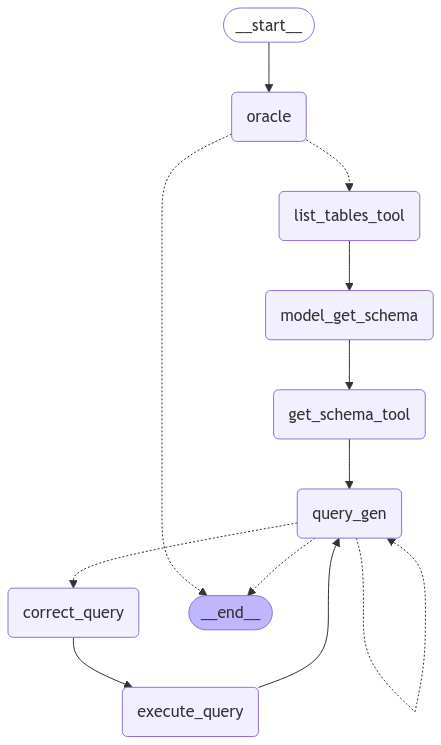

In [196]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [106]:
messages = app.invoke(
    {"messages": [("user", "What product sold the most?")]}
)
json_str = messages["messages"][-1].tool_calls[0]["args"]["final_answer"]
json_str

'The product that sold the most is the "Puffer Jacket" with a total quantity of 65 units sold.'

In [107]:
messages

{'messages': [HumanMessage(content='What product sold the most?', additional_kwargs={}, response_metadata={}, id='919cafe7-1b8a-4633-956d-7b86583390de'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, id='d89dd0c7-5337-4b71-872a-f7294e709c2d', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]),
  ToolMessage(content='product_data, purchase_data', name='sql_db_list_tables', id='fca145e6-144e-436f-ba2d-b5d3a98e9393', tool_call_id='tool_abcd123'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0wCGT2r9emjfwFY67e5frx7y', 'function': {'arguments': '{"table_names": "product_data"}', 'name': 'sql_db_schema'}, 'type': 'function'}, {'id': 'call_QzY7JcyQEjlTZP2MN0csGb4v', 'function': {'arguments': '{"table_names": "purchase_data"}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 151, 'total_tokens': 202, 'com

In [110]:
messages['messages'][-4].to_json()['kwargs']

{'content': "To determine which product sold the most, we need to sum the `purchase_qty` for each `product_id` in the `purchase_data` table and then join it with the `product_data` table to get the product name. Let's write the query to find this information.\n\n```sql\nSELECT \n    pd.product_name, \n    SUM(pch.purchase_qty) AS total_quantity_sold\nFROM \n    purchase_data pch\nJOIN \n    product_data pd ON pch.product_id = pd.product_id\nGROUP BY \n    pd.product_name\nORDER BY \n    total_quantity_sold DESC\nLIMIT 1;\n```",
 'additional_kwargs': {'refusal': None},
 'response_metadata': {'token_usage': {'completion_tokens': 129,
   'prompt_tokens': 754,
   'total_tokens': 883,
   'completion_tokens_details': {'accepted_prediction_tokens': 0,
    'audio_tokens': 0,
    'reasoning_tokens': 0,
    'rejected_prediction_tokens': 0},
   'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
  'model_name': 'gpt-4o-2024-08-06',
  'system_fingerprint': 'fp_9faba9f038',
  'finish

In [111]:
messages['messages'][-3].to_json()['kwargs']

{'content': '',
 'additional_kwargs': {'tool_calls': [{'id': 'call_ibd43E418mqCcF9YrBwT5cvz',
    'function': {'arguments': '{"query":"SELECT \\n    pd.product_name, \\n    SUM(pch.purchase_qty) AS total_quantity_sold\\nFROM \\n    purchase_data pch\\nJOIN \\n    product_data pd ON pch.product_id = pd.product_id\\nGROUP BY \\n    pd.product_name\\nORDER BY \\n    total_quantity_sold DESC\\nLIMIT 1;"}',
     'name': 'db_query_tool'},
    'type': 'function'}],
  'refusal': None},
 'response_metadata': {'token_usage': {'completion_tokens': 88,
   'prompt_tokens': 338,
   'total_tokens': 426,
   'completion_tokens_details': {'accepted_prediction_tokens': 0,
    'audio_tokens': 0,
    'reasoning_tokens': 0,
    'rejected_prediction_tokens': 0},
   'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
  'model_name': 'gpt-4o-2024-08-06',
  'system_fingerprint': 'fp_d28bcae782',
  'finish_reason': 'tool_calls',
  'logprobs': None},
 'type': 'ai',
 'id': 'run-bce8cb1c-272e-41d4-ae

In [14]:
messages

{'messages': [HumanMessage(content='What product sold the most?', additional_kwargs={}, response_metadata={}, id='2b98ca09-9e38-4e31-afce-7b989e0907db'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, id='df712d24-0d16-4300-8230-be81a76548dc', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]),
  ToolMessage(content='product_data, purchase_data', name='sql_db_list_tables', id='862a3012-3ef5-4093-b04c-8c95d60ebeb0', tool_call_id='tool_abcd123'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_clKf4NawseN1yiZo0CztSrlf', 'function': {'arguments': '{"table_names": "product_data"}', 'name': 'sql_db_schema'}, 'type': 'function'}, {'id': 'call_oBZcvRoeHKTawrVw0hYWjCHL', 'function': {'arguments': '{"table_names": "purchase_data"}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 151, 'total_tokens': 202, 'com

In [43]:
# for event in app.stream(
#     {"messages": [("user", "What product sold the most?")]}
# ):
#     print(event)

In [46]:
test =[
         AIMessage(content='', additional_kwargs={}, response_metadata={}, id='df712d24-0d16-4300-8230-be81a76548dc', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]),
         ToolMessage(content='product_data, purchase_data', name='sql_db_list_tables', id='862a3012-3ef5-4093-b04c-8c95d60ebeb0', tool_call_id='tool_abcd123')
         ]

In [48]:
# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [get_schema_tool]
)

a = model_get_schema.invoke(test)

In [50]:
a.tool_calls

[{'name': 'sql_db_schema',
  'args': {'table_names': 'product_data'},
  'id': 'call_UHonQJ1alrX6ha1hNUgLbkPo',
  'type': 'tool_call'},
 {'name': 'sql_db_schema',
  'args': {'table_names': 'purchase_data'},
  'id': 'call_7U9lfelmuAwA45A1zRWQPi8S',
  'type': 'tool_call'}]

# iMPORT TEST

In [1]:
import os
import sys
os.chdir('/app')
print(os.getcwd())

/app


In [2]:
from lang_model import chatbot
model = chatbot()

In [41]:
messages = model.invoke(
    {"messages": [("user", "What product sold the most?")]}
)

json_str = messages["messages"][-1].tool_calls[0]["args"]["final_answer"]
json_str

'The product that sold the most is the "Puffer Jacket" with a total quantity sold of 65 units.'

In [42]:
import json

# Iterate through the results and get the code snippet for each slice where 'db_query_tool' appears
query = []

for i, item in enumerate(messages["messages"]):
    try:
        tool_name = item.additional_kwargs["tool_calls"][0]["function"]["name"]
        if tool_name == "db_query_tool":
            a = item.additional_kwargs['tool_calls'][0]['function']['arguments']
            actual_dict = json.loads(a)
            query.append(actual_dict['query'])
            
    except:
        pass

query[-1]


'SELECT \n    pd.product_name, \n    SUM(pch.purchase_qty) AS total_quantity_sold\nFROM \n    purchase_data pch\nJOIN \n    product_data pd ON pch.product_id = pd.product_id\nGROUP BY \n    pd.product_name\nORDER BY \n    total_quantity_sold DESC\nLIMIT 1;'

In [43]:
print(query[-1])

SELECT 
    pd.product_name, 
    SUM(pch.purchase_qty) AS total_quantity_sold
FROM 
    purchase_data pch
JOIN 
    product_data pd ON pch.product_id = pd.product_id
GROUP BY 
    pd.product_name
ORDER BY 
    total_quantity_sold DESC
LIMIT 1;


```sql
SELECT \n    pd.product_name, \n    SUM(pch.purchase_qty) AS total_quantity_sold\nFROM \n    purchase_data pch\nJOIN \n    product_data pd ON pch.product_id = pd.product_id\nGROUP BY \n    pd.product_name\nORDER BY \n    total_quantity_sold DESC\nLIMIT 1;
```


In [235]:
import getpass
import os
from langchain_community.utilities import SQLDatabase
from dotenv import load_dotenv


load_dotenv('.env')
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")


# Database connection details
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("DB_NAME", "your_database_name")
DB_USER = os.getenv("DB_USER", "your_username")
DB_PASSWORD = os.getenv("DB_PASSWORD", "your_password")

engine = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

db = SQLDatabase.from_uri(engine)




from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")  # Get the error message of current state
    tool_calls = state["messages"][-1].tool_calls # Get the tool calls of the last message
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

toolkit = SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model="gpt-4o"))
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")


# print(list_tables_tool.invoke(""))
# print(get_schema_tool.invoke("purchase_data"))


from langchain_core.tools import tool


@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result


# print(db_query_tool.invoke("SELECT * FROM purchase_data LIMIT 10;"))





from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages


# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]



# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }

# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [get_schema_tool]
)




# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")








# Query check function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the postgres query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)


from langchain_core.tools import tool


@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result


# print(db_query_tool.invoke("SELECT * FROM purchase_data LIMIT 10;"))


query_check = query_check_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [db_query_tool], tool_choice="required"
)

# invoke_check = query_check.invoke({"messages": [("user", "SELECT * FROM purchase_data LIMIT 10;")]})

def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}




# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct postgres query to run, then look at the results of the query and return the answer.
If the user's input is not asking for data, do not generate a query, SubmitFinalAnswer and ask for clarification.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)

query_gen = query_gen_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [SubmitFinalAnswer, model_check_query]
)


def query_gen_node(state: State):
    """
    1. Invoke whatever state the workflow is in now.
    2. If tool_calls is not empty, and the tool is not submit final answer, return an error message.
    3. If tool_calls is empty return a blank tool message
    4. return invoked state + tool message

    This LLM generates a SQL query due to system prompt and then either check/runs the query or submits the final answer.
    """
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}



# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


import uuid

from langchain_core.chat_history import InMemoryChatMessageHistory

chats_by_session_id = {}


def get_chat_history(session_id: str) -> InMemoryChatMessageHistory:
    chat_history = chats_by_session_id.get(session_id)
    if chat_history is None:
        chat_history = InMemoryChatMessageHistory()
        chats_by_session_id[session_id] = chat_history
    return chat_history




# Add a node for a model to generate a query based on the question and schema
oracle_system = """
You are the oracle, the great AI decision maker.
If the user prompt is asking for data, use the list_tables_tool.
DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.
use only one tool

"""
oracle_prompt = ChatPromptTemplate.from_messages([
    ("system", query_gen_system), 
    ("placeholder", "{messages}"),
])

oracle_bind = oracle_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [list_tables_tool, SubmitFinalAnswer], tool_choice="required"
)



def run_oracle(state: State, config):
    message = oracle_bind.invoke(state)
    return {"messages": [message]}


# Define a conditional edge to decide whether to continue or end the workflow
def query_or_conv(state: State) -> Literal[END, "list_tables_tool"]:
    
    messages = state["messages"]
    # print(state)
    tool = messages[-1].additional_kwargs['tool_calls'][0]['function']['name']
    # print(tool)
    # If there is a tool call, then we finish
    if tool == 'SubmitFinalAnswer':
        return END
    elif tool == 'sql_db_list_tables':
        return "list_tables_tool"
    else:
        return "run_oracle"
    
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


def chatbot():

    workflow = StateGraph(State)
    workflow.add_node("oracle", run_oracle)
    # workflow.add_node("final_answer", final_answer)
    # workflow.add_node("first_tool_call", first_tool_call)
    workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
    workflow.add_node("model_get_schema", lambda state: {"messages": [model_get_schema.invoke(state["messages"])],},)
    workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))
    workflow.add_node("query_gen", query_gen_node)
    workflow.add_node("correct_query", model_check_query)
    workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))



    # Specify the edges between the nodes
    # workflow.add_edge(START, "first_tool_call")
    workflow.set_entry_point("oracle")

    workflow.add_conditional_edges("oracle",query_or_conv)

    # workflow.add_edge("oracle", "list_tables_tool")
    workflow.add_edge("list_tables_tool", "model_get_schema")
    workflow.add_edge("model_get_schema", "get_schema_tool")
    workflow.add_edge("get_schema_tool", "query_gen")

    workflow.add_conditional_edges(
        "query_gen",
        should_continue, # query_gen, correct_querry, END
    )
    workflow.add_edge("correct_query", "execute_query")
    workflow.add_edge("execute_query", "query_gen")

    # Compile the workflow into a runnable
    app = workflow.compile(checkpointer=memory)

    return app

In [253]:
model = chatbot()

import uuid

thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}

# session_id = uuid.uuid4()
# config = {"configurable": {"session_id": session_id}}

In [254]:
prompt = 'my name is jaeho'
messages = model.invoke({"messages": [("user", prompt)]}, config=config)
messages

{'messages': [HumanMessage(content='my name is jaeho', additional_kwargs={}, response_metadata={}, id='431f99f8-c7af-4506-9dc5-d10175cb663a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IwsQFsOzzSLwKJ6gdPy88VMb', 'function': {'arguments': '{"final_answer":"Hello Jaeho! How can I assist you today?"}', 'name': 'SubmitFinalAnswer'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 361, 'total_tokens': 390, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a6eb32b6-5462-4489-8ad7-28c8a46dd7c9-0', tool_calls=[{'name': 'SubmitFinalAnswer', 'args': {'final_answer': 'Hello Jaeho! How can I assist you today?'}, 'id': 

In [251]:
model.get_state_history(config=config)

<generator object Pregel.get_state_history at 0x7f7b7ea7a340>

In [255]:
messages

{'messages': [HumanMessage(content='my name is jaeho', additional_kwargs={}, response_metadata={}, id='431f99f8-c7af-4506-9dc5-d10175cb663a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IwsQFsOzzSLwKJ6gdPy88VMb', 'function': {'arguments': '{"final_answer":"Hello Jaeho! How can I assist you today?"}', 'name': 'SubmitFinalAnswer'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 361, 'total_tokens': 390, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a6eb32b6-5462-4489-8ad7-28c8a46dd7c9-0', tool_calls=[{'name': 'SubmitFinalAnswer', 'args': {'final_answer': 'Hello Jaeho! How can I assist you today?'}, 'id': 

In [238]:
prompt = 'what is my name?'
messages = model.invoke({"messages": [("user", prompt)]}, config=config)
messages

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_RELk48icpkqCu5TH9E0cw78x", 'type': 'invalid_request_error', 'param': 'messages.[3].role', 'code': None}}

In [70]:
@tool("final_answer")
def final_answer(summary: str):
    """
    Create a simple response for the user input based on memory
    """
    return ""

# Add a node for a model to generate a query based on the question and schema
oracle_system = """
You are the oracle, the great AI decision maker.
If the user prompt is asking for data, use the list_tables_tool.
If the user is engaging in a conversation, use final_answer.
use only one tool

"""
oracle_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)

oracle = query_gen_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [list_tables_tool, final_answer], tool_choice="required"
)

In [80]:
c = oracle.invoke({"messages": [("user", "Hi")]})

In [81]:
q = oracle.invoke({"messages": [("user", "What product was sold the most?")]})

In [82]:
print(c.tool_calls[0]['name'])
print(q.tool_calls[0]['name'])

final_answer
sql_db_list_tables


In [91]:
c

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KVWcT70rOck1GsgPz97FkaQm', 'function': {'arguments': '{"summary":"Hello! How can I assist you today?"}', 'name': 'final_answer'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 345, 'total_tokens': 368, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1904c727-1abc-466d-a0c7-6fb4befb68a5-0', tool_calls=[{'name': 'final_answer', 'args': {'summary': 'Hello! How can I assist you today?'}, 'id': 'call_KVWcT70rOck1GsgPz97FkaQm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 345, 'output_tokens': 23, 'total_tokens': 368, 'input_token_details': {'audio': 0, 'cache